### Genis Skura - 2. Classical Cryptography

In [181]:
# Import useful libraries
import cv2
import numpy as np
import skimage.color as clr
import skimage.transform as trf
import skimage.util as uti
from Crypto.Cipher import AES
from Crypto.Random import get_random_bytes
from copy import copy
from matplotlib import pyplot as plt

(-0.5, 63.5, 63.5, -0.5)

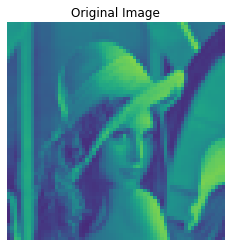

In [182]:
# read in the image, convert it to the right size 64x64 and plot for verification
im = cv2.imread('lena.png')
im = clr.rgb2gray(im)
im = uti.img_as_ubyte(trf.resize(im, (64,64)))

plt.imshow(im, vmin=0, vmax=255)
plt.title('Original Image')
plt.axis('off')

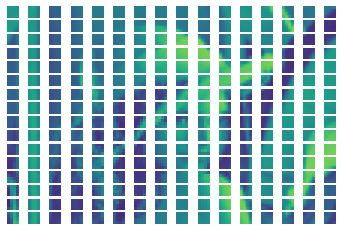

In [183]:
# chunk image procedure in blocks 4x4 and verify it works
blk_size = 4
n_blk = int(64/blk_size)
fig, axs = plt.subplots(n_blk, n_blk)
for i in range(n_blk**2):
   axs[int(i//n_blk), int(i%n_blk)].imshow(im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)], vmin=0, vmax=255)
   axs[int(i//n_blk), int(i%n_blk)].axis('off')

(-0.5, 63.5, 63.5, -0.5)

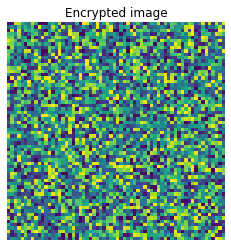

In [184]:
# Encryption of each 4x4 blocks (16 bytes of data) by AES-256 method and show encrypted image
enc_im = copy(im)
key = get_random_bytes(16)
cipher = AES.new(key, AES.MODE_EAX)
nonce = cipher.nonce

for i in range(n_blk**2):
    subim = im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)]
    enc_im[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)] = np.reshape(np.frombuffer(cipher.encrypt(subim.tobytes()), dtype = subim.dtype), subim.shape)
plt.imshow(enc_im, vmin=0, vmax=255)
plt.title('Encrypted image')
plt.axis('off')

In [185]:
from skimage import util
# model your attack here
def additive_white_noise(image, variance):
    white_noise =  np.sqrt(variance) * np.random.randn(image.shape[0], image.shape[1]) + 0 # white noise is ok
    noizy_img = util.img_as_float(image) + white_noise    # 
    return util.img_as_ubyte(np.clip(noizy_img, -1, 1))   # np.clip to limit the float values of the array only [-1 to 1] for conversion to uint8 [0, 255]


test_enc_im = np.copy(enc_im)

# random single bit error
test_enc_im[np.random.choice(test_enc_im.shape[0])][np.random.choice(test_enc_im.shape[1])] = np.random.choice(255)
test_enc_im[np.random.choice(test_enc_im.shape[0])][np.random.choice(test_enc_im.shape[1])] = 255

# noise
variance = 0.001
noizy_img = additive_white_noise(np.copy(enc_im), variance)

(-0.5, 63.5, 63.5, -0.5)

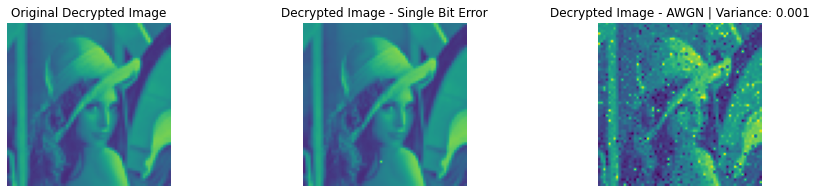

In [186]:
# Decryption and show decrypted image
def decrypt(img, n_blk, blk_size, key, nonce):
    decrypted = np.copy(img)
    cipher = AES.new(key, AES.MODE_EAX, nonce = nonce)
    for i in range(n_blk ** 2):
        subim = img[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)]
        decrypted[blk_size*int(i//n_blk):blk_size*(int(i//n_blk)+1), blk_size*int(i%n_blk):blk_size*(int(i%n_blk)+1)] = np.reshape(np.frombuffer(cipher.decrypt(subim.tobytes()), dtype = subim.dtype), subim.shape)
    return decrypted

dec_im1 = decrypt(enc_im, n_blk, blk_size, key, nonce)
dec_im2 = decrypt(test_enc_im, n_blk, blk_size, key, nonce)
dec_im3 = decrypt(noizy_img, n_blk, blk_size, key, nonce)


fig1, axes = plt.subplots(1, 3, figsize = (15, 3))
ax = axes.ravel()
ax[0].imshow(dec_im1, vmin=0, vmax=255)
ax[0].set_title('Original Decrypted Image')
ax[0].axis('off')

ax[1].imshow(dec_im2, vmin=0, vmax=255)
ax[1].set_title('Decrypted Image - Single Bit Error')
ax[1].axis('off')

ax[2].imshow(dec_im3, vmin=0, vmax=255)
ax[2].set_title('Decrypted Image - AWGN | Variance: {}'.format(variance))
ax[2].axis('off')

Through this exercise we could understand the sensitivity of classical cryptography to the smallest type of modification to the original image as seen above at the single bit of error. While in the case of the white gaussian noise the difference is very noticeable after decryption. However, we sometimes want to tolerate some modifications to our image (after compression or noise through communication channels) so classical cryptography isn't the way to go forward.